<font color=grey>imports [hidden]</font>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
import cPickle as pkl
import pandas as pd
import os,sys,glob, h5py

from braintv_ephys_dev.workstation.danield import generalephys as ephys
from braintv_ephys_dev.workstation.danield.generalephys import placeAxesOnGrid, cleanAxes
from braintv_ephys_dev.workstation.danield import utils
from braintv_ephys_dev.workstation.danield import rf_analysis
from braintv_ephys_dev.workstation.danield import psth_and_raster as psth
from braintv_ephys_dev.workstation.danield import reliability_and_precision as rp


import seaborn as sns
sns.set_style('white')
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

failed to import CV2 in core.utilities


/Users/administrator/anaconda/lib/python2.7/site-packages/imaging_behavior/core/tifffile.py:2170: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
/Users/administrator/anaconda/lib/python2.7/site-packages/imaging_behavior/core/tifffile.py:2170: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
/Users/administrator/anaconda/lib/python2.7/site-packages/imaging_behavior/core/tifffile.py:2170: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


set up the paths to all of the data<br></br>
data are hdf5 files in psuedo-NWB, pending update to nwb2.0

In [2]:
folder = '/Volumes/DATA2/temporal/nwbs' 
#paths = glob.glob(folder+'/*.nwb')
v1_paths = [os.path.join(folder,'M276039_insertion2_V1_angled_sort2_2.nwb'),
        os.path.join(folder,'M310008_07-27-13_v1_angled_d.nwb'),
        os.path.join(folder,'M310008_07-35-06_v1_angled_d.nwb'),
        os.path.join(folder,'M310008_08-23-22_v1_angled1_d2.nwb'),
         os.path.join(folder,'M310008_08-52-48_v1_angled3_d2.nwb'),
        os.path.join(folder,'M310008_08-52-48_v1_angled3_d2.nwb'),
            os.path.join(folder,'M310017_09-23-41_v1_angled1.nwb'),
            os.path.join(folder,'M227382_insertion1_withDepths11.nwb'),
           os.path.join(folder,'M227398_insertion1_withEyetracking.nwb'),
            #os.path.join(folder,'M230381_insertion2_V1.nwb'),
            os.path.join(folder,'M260686_insertion1_V1_withEyetracking3.nwb'),
            os.path.join(folder,'M270512_insertion2_V1_angled3_6.nwb'),
            os.path.join(folder,'M276038_insertion3_V1_angled_7.nwb'),
           ]
lgn_paths = [#os.path.join(folder,'M227382_insertion2_LGN.nwb'),
            os.path.join(folder,'M260866_insertion2_withEyetracking1.nwb'),
            os.path.join(folder,'M270511_insertion5.nwb')]
dual_paths = glob.glob(os.path.join(folder,'M31989*.nwb'))

figure_folder = '/Volumes/DATA2/temporal/figures'

load a data frame that contains all of the data, from ~this~ notebook<br></br>
this has waveform classification and some calculations of single cell response metrics

In [3]:
#df = pd.read_csv('/Volumes/SD1/DanD/temporal/combined_df_2.df')
df = pd.read_csv('/Volumes/SD1/DanD/temporal/combined_dfv_reliability.df')
df_v1 = df[df.structure=='V1']
df_lgn =df[df.structure=='LGN']
print df.columns
# modify the LGN depth because the offset due to electrode penetration depth was not added to the NWB.
for index in df_lgn.index:
    d = df_lgn.depth[index]
    if d < 1500.:
        df_lgn.depth[index]=d+1900.# just an approximation for now.

Index([u'Unnamed: 0', u'Unnamed: 0.1', u'nwb_id', u'mouse', u'experiment',
       u'probe', u'structure', u'cell', u'times', u'ypos', u'xpos', u'depth',
       u'waveform', u'template', u'waveform_duration', u'waveform_PTratio',
       u'waveform_repolarizationslope', u'waveform_class', u'sparseness',
       u'image_spikecount_matrix', u'shuffled', u'images_max_rate',
       u'jitter_best', u'jitter_all', u'responsive_images', u'jitter_median',
       u'first_spikes_images', u'Rfsj', u'Rfsj_pair_id', u'Rfsj_pair_id_old',
       u'Rfsj_s', u'Rfsj_p', u'Rfsj_k', u'Rfsj_s2', u'Rfsj_p2', u'Rfsj_k2',
       u'Rfsj_s_shuffled', u'Rfsj_p_shuffled', u'Rfsj_k_shuffled',
       u'Rfsj_s2_shuffled', u'Rfsj_p2_shuffled', u'Rfsj_k2_shuffled',
       u'reliability'],
      dtype='object')


In [4]:
dft=df

load nwbs into a dictionary for ease of use 

In [5]:
nwbs={}
for nwb_path in dfv.nwb_id.unique():
    nwbs[nwb_path]=h5py.File(nwb_path)

NameError: name 'dfv' is not defined

plot the number of cells recorded in each experiment

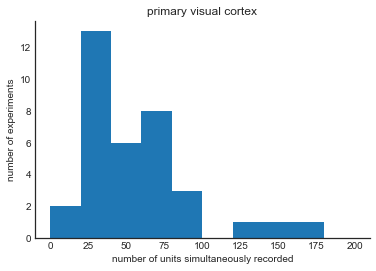

In [53]:
dft =df[df.structure=='V1'] #get only the V1 cells
num_cells = [dft[dft.nwb_id==nwb_path].shape[0] for nwb_path in dft.nwb_id.unique()]
plt.hist(num_cells,range=(0,200),bins=10)
plt.xlabel('number of units simultaneously recorded');plt.ylabel('number of experiments')
plt.title('primary visual cortex')
ephys.cleanAxes(plt.gca(),bottomLabels=True,leftLabels=True)

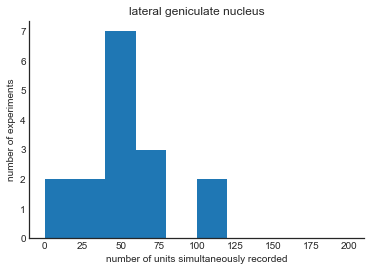

In [54]:
dft =df[df.structure=='LGN'] #get only the V1 cells
num_cells = [dft[dft.nwb_id==nwb_path].shape[0] for nwb_path in dft.nwb_id.unique()]
plt.hist(num_cells,range=(0,200),bins=10)
plt.xlabel('number of units simultaneously recorded');plt.ylabel('number of experiments')
plt.title('lateral geniculate nucleus')
ephys.cleanAxes(plt.gca(),bottomLabels=True,leftLabels=True)

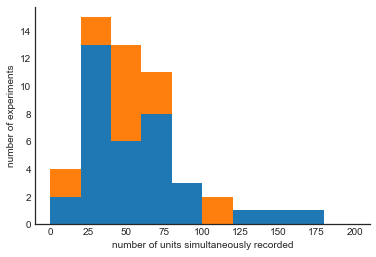

In [21]:
dft =df[df.structure=='V1'] #get only the V1 cells
num_cells_v1 = [dft[dft.nwb_id==nwb_path].shape[0] for nwb_path in dft.nwb_id.unique()]
dft =df[df.structure=='LGN'] #get only the V1 cells
num_cells_lgn = [dft[dft.nwb_id==nwb_path].shape[0] for nwb_path in dft.nwb_id.unique()]
plt.hist([num_cells_v1,num_cells_lgn],range=(0,200),bins=10,stacked=True)
plt.xlabel('number of units simultaneously recorded');plt.ylabel('number of experiments')
#plt.title('')
ephys.cleanAxes(plt.gca(),bottomLabels=True,leftLabels=True)
plt.gcf().savefig(os.path.join(figure_folder,'units_experiments.eps'),format='eps')

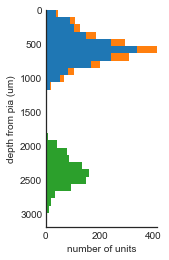

In [30]:
dft = df[df.structure=='V1'][df.waveform_class=='rs'] #get only the V1 cells
depth_cells_v1_rs = []
dump = [depth_cells_v1_rs.extend(np.array(dft.depth[dft.nwb_id==nwb_path]).tolist()) for nwb_path in dft.nwb_id.unique()]

dft = df[df.structure=='V1'][df.waveform_class=='fs'] #get only the V1 cells
depth_cells_v1_fs = []
dump = [depth_cells_v1_fs.extend(np.array(dft.depth[dft.nwb_id==nwb_path]).tolist()) for nwb_path in dft.nwb_id.unique()]

dft = df_lgn #get only the LGN cells
depth_cells_lgn = []
dump = [depth_cells_lgn.extend(np.array(dft.depth[dft.nwb_id==nwb_path]).tolist()) for nwb_path in dft.nwb_id.unique()]

f,ax=plt.subplots(1,figsize=(2,4))
plt.hist([depth_cells_v1_rs,depth_cells_v1_fs,depth_cells_lgn],bins=30,range=(0,3200),stacked=True,orientation="horizontal")
plt.ylabel('depth from pia (um)');plt.xlabel('number of units')
plt.ylim(3200,0)
ephys.cleanAxes(plt.gca(),bottomLabels=True,leftLabels=True)
#plt.gcf().savefig(os.path.join(figure_folder,'depth_units.eps'),format='eps')

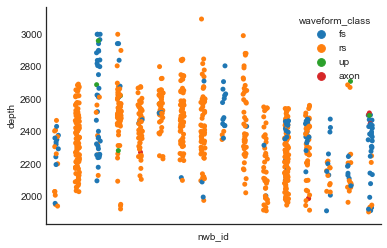

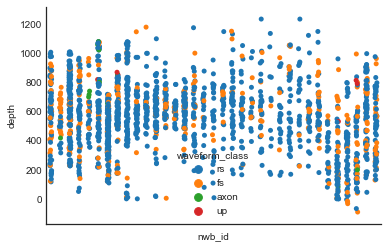

In [124]:
f,ax=plt.subplots(1)
g=sns.stripplot(x='nwb_id',y='depth',data=df_lgn,hue='waveform_class',jitter=True,ax=ax)
plt.xticks(rotation=90)
ephys.cleanAxes(plt.gca(),leftLabels=True)
f,ax=plt.subplots(1)
g=sns.stripplot(x='nwb_id',y='depth',data=df_v1,hue='waveform_class',jitter=True,ax=ax)
plt.xticks(rotation=90)
ephys.cleanAxes(plt.gca(),leftLabels=True)

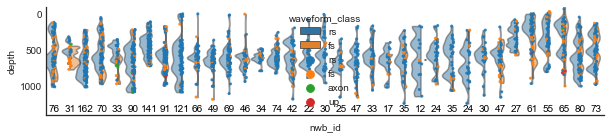

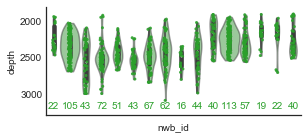

In [25]:
f,ax=plt.subplots(1,figsize=(10,2))
g=sns.violinplot(x='nwb_id',y='depth',data=pd.concat((df_v1[df_v1.waveform_class=='rs'],df_v1[df_v1.waveform_class=='fs'])),
                 hue='waveform_class',split=True,ax=ax,cut=0,bw=0.2,inner=None,scale='count',width=1.3)
for art in g.get_children():
    if isinstance(art, PolyCollection):
        art.set_alpha(0.5)
g=sns.stripplot(x='nwb_id',y='depth',data=df_v1,hue='waveform_class',jitter=True,ax=ax,alpha=0.9,s=3)
plt.xticks(rotation=90)
plt.ylim(1400,-100)
ephys.cleanAxes(plt.gca(),leftLabels=True)
ax=plt.gca()
dump=[ax.text(p[0],1350, p[1], ha='center', color='k') for p in zip(ax.get_xticks(),[df_v1[df_v1.nwb_id==nwb_path].shape[0] for nwb_path in df_v1.nwb_id.unique()])]
plt.gcf().savefig(os.path.join(figure_folder,'depth_v1experiments.eps'),format='eps')

f,ax=plt.subplots(1,figsize=(10*len(df_lgn.nwb_id.unique())/float(len(df_v1.nwb_id.unique())),2))
g=sns.violinplot(x='nwb_id',y='depth',data=df_lgn,ax=ax,color=sns.color_palette()[2],cut=0,scale='count',width=1.3)
for art in g.get_children():
    if isinstance(art, PolyCollection):
        art.set_alpha(0.5)
g=sns.stripplot(x='nwb_id',y='depth',data=df_lgn,jitter=True,ax=ax,alpha=0.9,color=sns.color_palette()[2],s=3)
plt.xticks(rotation=90)
plt.ylim(3300,1800)
ephys.cleanAxes(plt.gca(),leftLabels=True)
ax=plt.gca()
dump=[ax.text(p[0],3200, p[1], ha='center', color=sns.color_palette()[2]) for p in zip(ax.get_xticks(),[df_lgn[df_lgn.nwb_id==nwb_path].shape[0] for nwb_path in df_lgn.nwb_id.unique()])]
plt.gcf().savefig(os.path.join(figure_folder,'depth_lgnexperiments.eps'),format='eps')


the example pulled for the figure is: /Volumes/DATA2/temporal/nwbs/M319892_dual_25082017.nwb 73

### individual cell metrics
lifetime sparseness

[]

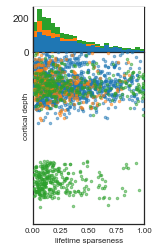

In [65]:
dft=pd.concat([df_v1,df_lgn])
metric = 'sparseness'
limits = (0,1.)

f,axis=plt.subplots(1,1,figsize=(2,4))
ax = placeAxesOnGrid(f,[1,1],xspan=[0,1],yspan=[0,0.21])
ax.hist([dft[dft.structure=='V1'][dft.waveform_class=='rs'][metric],
         dft[dft.structure=='V1'][dft.waveform_class=='fs'][metric],
          dft[dft.structure=='LGN'][metric]],range=(limits[0],limits[1]),
           bins=25,stacked=True)
ax.set_xlim(limits[0],limits[1])
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis=u'both', which=u'both',length=0)
#axis.axis('off')
cleanAxes(ax,leftLabels=True)

ax = placeAxesOnGrid(f,[1,1],xspan=[0,1],yspan=[0.21,1.])
ax.axis('off')
ax.plot(dft[dft.structure=='V1'][dft.waveform_class=='rs'][metric],
        dft[dft.structure=='V1'][dft.waveform_class=='rs'].depth,'o',ms=2.5,alpha=0.5)
ax.plot(dft[dft.structure=='V1'][dft.waveform_class=='fs'][metric],
        dft[dft.structure=='V1'][dft.waveform_class=='fs'].depth,'o',ms=2.5,alpha=0.5)
ax.plot(dft[dft.structure=='LGN'][metric],
        dft[dft.structure=='LGN'].depth,'o',ms=2.5,alpha=0.5)

ax.set_ylim(3000,0)
ax.set_xlim(limits[0],limits[1])

axis.set_xlabel('lifetime sparseness',size=8)
axis.set_ylabel('cortical depth',size=8)
axis.tick_params(axis='both', which='major', labelsize=8)
axis.get_yaxis().set_ticks([])


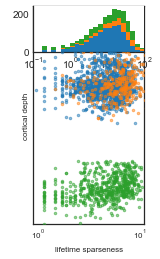

In [15]:
dft=pd.concat([df_v1,df_lgn])
metric = 'images_max_rate'
limits = (0.1,100.)

f,axis=plt.subplots(1,1,figsize=(2,4))
ax = placeAxesOnGrid(f,[1,1],xspan=[0,1],yspan=[0,0.21])
ax.hist([dft[dft.structure=='V1'][dft.waveform_class=='rs'][metric],
         dft[dft.structure=='V1'][dft.waveform_class=='fs'][metric],
          dft[dft.structure=='LGN'][metric]],range=(limits[0],limits[1]),
        bins=np.logspace(np.log10(limits[0]),np.log10(limits[1]),25),
        stacked=True)
ax.set_xlim(limits[0],limits[1])
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis=u'both', which=u'both',length=0)
#axis.axis('off')
cleanAxes(ax,leftLabels=True)
ax.set_xscale('log')
ax = placeAxesOnGrid(f,[1,1],xspan=[0,1],yspan=[0.21,1.])
ax.axis('off')
ax.plot(dft[dft.structure=='V1'][dft.waveform_class=='rs'][metric],
        dft[dft.structure=='V1'][dft.waveform_class=='rs'].depth,'o',ms=2.5,alpha=0.5)
ax.plot(dft[dft.structure=='V1'][dft.waveform_class=='fs'][metric],
        dft[dft.structure=='V1'][dft.waveform_class=='fs'].depth,'o',ms=2.5,alpha=0.5)
ax.plot(dft[dft.structure=='LGN'][metric],
        dft[dft.structure=='LGN'].depth,'o',ms=2.5,alpha=0.5)

ax.set_ylim(3000,0)
ax.set_xlim(limits[0],limits[1])
ax.set_xscale('log')
axis.set_xscale('log')
axis.set_xlabel('lifetime sparseness',size=8)
axis.set_ylabel('cortical depth',size=8)
axis.tick_params(axis='both', which='major', labelsize=8)
axis.get_yaxis().set_ticks([])
plt.gcf().savefig(os.path.join(figure_folder,'rate_log.png'),format='png')
plt.gcf().savefig(os.path.join(figure_folder,'rate_log.eps'),format='eps')

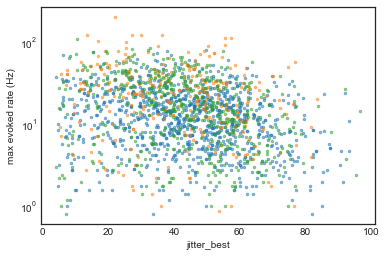

In [23]:
metric='jitter_best'
f,ax = plt.subplots(1)
ax.plot(dft[dft.structure=='V1'][dft.waveform_class=='rs'][metric],
        dft[dft.structure=='V1'][dft.waveform_class=='rs'].images_max_rate,'o',ms=2.5,alpha=0.5)
ax.plot(dft[dft.structure=='V1'][dft.waveform_class=='fs'][metric],
        dft[dft.structure=='V1'][dft.waveform_class=='fs'].images_max_rate,'o',ms=2.5,alpha=0.5)
ax.plot(dft[dft.structure=='LGN'][metric],
        dft[dft.structure=='LGN'].images_max_rate,'o',ms=2.5,alpha=0.5)
plt.yscale('log')
plt.ylabel('max evoked rate (Hz)')
plt.xlabel(metric)
plt.gcf().savefig(os.path.join(figure_folder,'rate_v_jitter.png'),format='png')

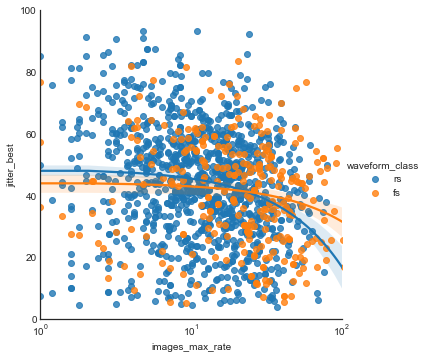

In [36]:
g=sns.lmplot(x='images_max_rate',y=metric,hue='waveform_class',data=dft[dft.structure=='V1'][dft.waveform_class!='axon'][dft.waveform_class!='up'])
plt.xlim(1,100);plt.xscale('log')
plt.ylim(0,100)
plt.gcf().savefig(os.path.join(figure_folder,'rate_v_jitter_v1.eps'),format='eps')

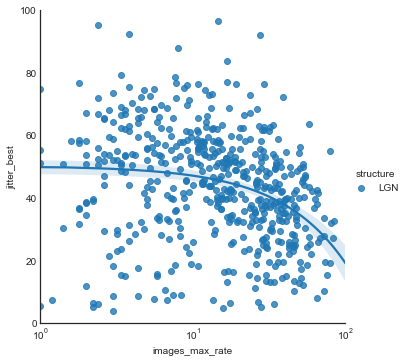

In [37]:
g=sns.lmplot(x='images_max_rate',y=metric,hue='structure',data=dft[dft.structure=='LGN'])
plt.xlim(1,100);plt.xscale('log')
plt.ylim(0,100)
plt.gcf().savefig(os.path.join(figure_folder,'rate_v_jitter_lgn.eps'),format='eps')

jitter

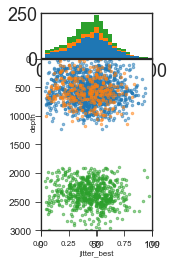

In [162]:
dft=pd.concat([df_v1,df_lgn])
metric = 'jitter_best'
limits = (0,100.)

f,axis=plt.subplots(1,1,figsize=(2,4))
ax = placeAxesOnGrid(f,[1,1],xspan=[0,1],yspan=[0,0.21])
ax.hist([dft[dft.structure=='V1'][dft.waveform_class=='rs'][metric],
         dft[dft.structure=='V1'][dft.waveform_class=='fs'][metric],
          dft[dft.structure=='LGN'][metric]],range=(limits[0],limits[1]),
           bins=25,stacked=True)
ax.set_xlim(limits[0],limits[1])
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis=u'both', which=u'both',length=0)
#axis.axis('off')
#cleanAxes(ax,leftLabels=True)

ax = placeAxesOnGrid(f,[1,1],xspan=[0,1],yspan=[0.21,1.])
ax.plot(dft[dft.structure=='V1'][dft.waveform_class=='rs'][metric],
        dft[dft.structure=='V1'][dft.waveform_class=='rs'].depth,'o',ms=2.5,alpha=0.5)
ax.plot(dft[dft.structure=='V1'][dft.waveform_class=='fs'][metric],
        dft[dft.structure=='V1'][dft.waveform_class=='fs'].depth,'o',ms=2.5,alpha=0.5)
ax.plot(dft[dft.structure=='LGN'][metric],
        dft[dft.structure=='LGN'].depth,'o',ms=2.5,alpha=0.5)

ax.set_ylim(3000,0)
ax.set_xlim(limits[0],limits[1])

axis.set_xlabel(metric,size=8)
axis.set_ylabel('depth',size=8)
axis.tick_params(axis='both', which='major', labelsize=8)
axis.get_yaxis().set_ticks([])
plt.gcf().savefig('/Users/administrator/Dropbox/allenTransfer/temporal_figs/metric_jitter.eps',format='eps')

In [163]:
dft.columns

Index([u'Unnamed: 0', u'Unnamed: 0.1', u'nwb_id', u'mouse', u'experiment',
       u'probe', u'structure', u'cell', u'times', u'ypos', u'xpos', u'depth',
       u'waveform', u'template', u'waveform_duration', u'waveform_PTratio',
       u'waveform_repolarizationslope', u'waveform_class', u'sparseness',
       u'image_spikecount_matrix', u'shuffled', u'images_max_rate',
       u'jitter_best', u'jitter_all', u'responsive_images', u'jitter_median',
       u'first_spikes_images', u'Rfsj', u'Rfsj_pair_id', u'Rfsj_pair_id_old',
       u'Rfsj_s', u'Rfsj_p', u'Rfsj_k', u'Rfsj_s2', u'Rfsj_p2', u'Rfsj_k2',
       u'Rfsj_s_shuffled', u'Rfsj_p_shuffled', u'Rfsj_k_shuffled',
       u'Rfsj_s2_shuffled', u'Rfsj_p2_shuffled', u'Rfsj_k2_shuffled',
       u'reliability'],
      dtype='object')

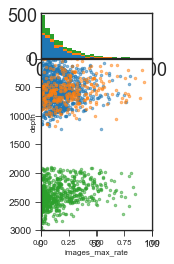

In [164]:
dft=pd.concat([df_v1,df_lgn])
metric = 'images_max_rate'
limits = (0,100.)

f,axis=plt.subplots(1,1,figsize=(2,4))
ax = placeAxesOnGrid(f,[1,1],xspan=[0,1],yspan=[0,0.21])
ax.hist([dft[dft.structure=='V1'][dft.waveform_class=='rs'][metric],
         dft[dft.structure=='V1'][dft.waveform_class=='fs'][metric],
          dft[dft.structure=='LGN'][metric]],range=(limits[0],limits[1]),
           bins=25,stacked=True)
ax.set_xlim(limits[0],limits[1])
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis=u'both', which=u'both',length=0)
#axis.axis('off')
#cleanAxes(ax,leftLabels=True)

ax = placeAxesOnGrid(f,[1,1],xspan=[0,1],yspan=[0.21,1.])
ax.plot(dft[dft.structure=='V1'][dft.waveform_class=='rs'][metric],
        dft[dft.structure=='V1'][dft.waveform_class=='rs'].depth,'o',ms=2.5,alpha=0.5)
ax.plot(dft[dft.structure=='V1'][dft.waveform_class=='fs'][metric],
        dft[dft.structure=='V1'][dft.waveform_class=='fs'].depth,'o',ms=2.5,alpha=0.5)
ax.plot(dft[dft.structure=='LGN'][metric],
        dft[dft.structure=='LGN'].depth,'o',ms=2.5,alpha=0.5)

ax.set_ylim(3000,0)
ax.set_xlim(limits[0],limits[1])

axis.set_xlabel(metric,size=8)
axis.set_ylabel('depth',size=8)
axis.tick_params(axis='both', which='major', labelsize=8)
axis.get_yaxis().set_ticks([])
plt.gcf().savefig('/Users/administrator/Dropbox/allenTransfer/temporal_figs/metric_evokedrate.eps',format='eps')

In [184]:
dft.columns

Index([u'Unnamed: 0', u'Unnamed: 0.1', u'nwb_id', u'mouse', u'experiment',
       u'probe', u'structure', u'cell', u'times', u'ypos', u'xpos', u'depth',
       u'waveform', u'template', u'waveform_duration', u'waveform_PTratio',
       u'waveform_repolarizationslope', u'waveform_class', u'sparseness',
       u'image_spikecount_matrix', u'shuffled', u'images_max_rate',
       u'jitter_best', u'jitter_all', u'responsive_images', u'jitter_median',
       u'first_spikes_images', u'Rfsj', u'Rfsj_pair_id', u'Rfsj_pair_id_old',
       u'Rfsj_s', u'Rfsj_p', u'Rfsj_k', u'Rfsj_s2', u'Rfsj_p2', u'Rfsj_k2',
       u'Rfsj_s_shuffled', u'Rfsj_p_shuffled', u'Rfsj_k_shuffled',
       u'Rfsj_s2_shuffled', u'Rfsj_p2_shuffled', u'Rfsj_k2_shuffled',
       u'reliability', u'reliability_flicker', u'reliability_movie'],
      dtype='object')

In [193]:
metric = 'jitter_best'

In [195]:
z = dft[dft.structure=='V1'][dft.waveform_class=='rs'][metric]
print 'V1 RS: '+str(np.mean(z))+' +/- '+str(np.std(z)/np.sqrt(len(z)))
z = dft[dft.structure=='V1'][dft.waveform_class=='fs'][metric]
print 'V1 FS: '+str(np.mean(z))+' +/- '+str(np.std(z)/np.sqrt(len(z)))
z = dft[dft.structure=='LGN'][metric]
print 'LGN: '+str(np.mean(z))+' +/- '+str(np.std(z)/np.sqrt(len(z)))


V1 RS: 44.8226037784 +/- 0.446754015714
V1 FS: 41.503100048 +/- 0.882615804718
LGN: 44.043745836 +/- 0.584174635956


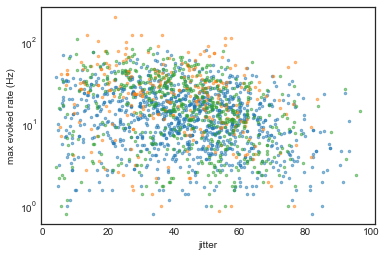

In [71]:
f,ax = plt.subplots(1)
ax.plot(dft[dft.structure=='V1'][dft.waveform_class=='rs'][metric],
        dft[dft.structure=='V1'][dft.waveform_class=='rs'].images_max_rate,'o',ms=2.5,alpha=0.5)
ax.plot(dft[dft.structure=='V1'][dft.waveform_class=='fs'][metric],
        dft[dft.structure=='V1'][dft.waveform_class=='fs'].images_max_rate,'o',ms=2.5,alpha=0.5)
ax.plot(dft[dft.structure=='LGN'][metric],
        dft[dft.structure=='LGN'].images_max_rate,'o',ms=2.5,alpha=0.5)
plt.yscale('log')
plt.ylabel('max evoked rate (Hz)')
plt.xlabel('jitter')
# plt.gcf().savefig(os.path.join(figure_folder,'rate_v_lifetimesparseness.png'),format='png')

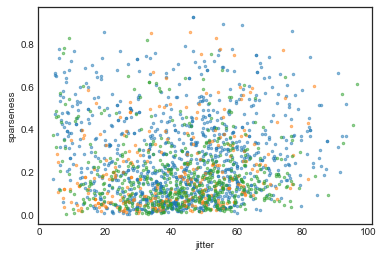

In [75]:
f,ax = plt.subplots(1)
ax.plot(dft[dft.structure=='V1'][dft.waveform_class=='rs'][metric],
        dft[dft.structure=='V1'][dft.waveform_class=='rs'].sparseness,'o',ms=2.5,alpha=0.5)
ax.plot(dft[dft.structure=='V1'][dft.waveform_class=='fs'][metric],
        dft[dft.structure=='V1'][dft.waveform_class=='fs'].sparseness,'o',ms=2.5,alpha=0.5)
ax.plot(dft[dft.structure=='LGN'][metric],
        dft[dft.structure=='LGN'].sparseness,'o',ms=2.5,alpha=0.5)
#plt.yscale('log')
plt.ylabel('sparseness')
plt.xlabel('jitter')

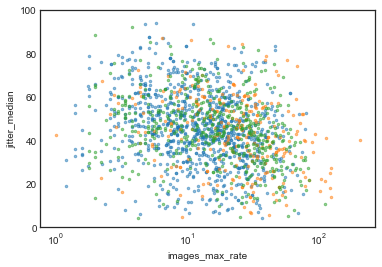

In [105]:
metric1='images_max_rate'
metric2='jitter_median'
f,ax = plt.subplots(1)
ax.plot(dft[dft.structure=='V1'][dft.waveform_class=='rs'][metric1],
        dft[dft.structure=='V1'][dft.waveform_class=='rs'][metric2],'o',ms=2.5,alpha=0.5)
ax.plot(dft[dft.structure=='V1'][dft.waveform_class=='fs'][metric1],
        dft[dft.structure=='V1'][dft.waveform_class=='fs'][metric2],'o',ms=2.5,alpha=0.5)
ax.plot(dft[dft.structure=='LGN'][metric1],
        dft[dft.structure=='LGN'][metric2],'o',ms=2.5,alpha=0.5)
plt.xscale('log')
plt.ylim(0,100)
plt.ylabel(metric2)
plt.xlabel(metric1)

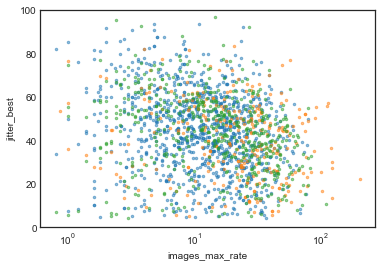

In [106]:
metric1='images_max_rate'
metric2='jitter_best'
f,ax = plt.subplots(1)
ax.plot(dft[dft.structure=='V1'][dft.waveform_class=='rs'][metric1],
        dft[dft.structure=='V1'][dft.waveform_class=='rs'][metric2],'o',ms=2.5,alpha=0.5)
ax.plot(dft[dft.structure=='V1'][dft.waveform_class=='fs'][metric1],
        dft[dft.structure=='V1'][dft.waveform_class=='fs'][metric2],'o',ms=2.5,alpha=0.5)
ax.plot(dft[dft.structure=='LGN'][metric1],
        dft[dft.structure=='LGN'][metric2],'o',ms=2.5,alpha=0.5)
plt.xscale('log')
plt.ylim(0,100)
plt.ylabel(metric2)
plt.xlabel(metric1)

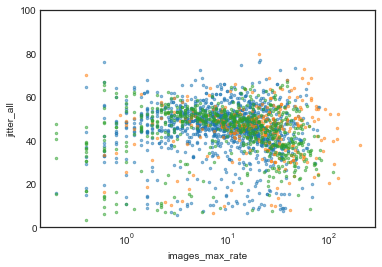

In [104]:
metric1='images_max_rate'
metric2='jitter_all'
f,ax = plt.subplots(1)
ax.plot(dft[dft.structure=='V1'][dft.waveform_class=='rs'][metric1],
        dft[dft.structure=='V1'][dft.waveform_class=='rs'][metric2],'o',ms=2.5,alpha=0.5)
ax.plot(dft[dft.structure=='V1'][dft.waveform_class=='fs'][metric1],
        dft[dft.structure=='V1'][dft.waveform_class=='fs'][metric2],'o',ms=2.5,alpha=0.5)
ax.plot(dft[dft.structure=='LGN'][metric1],
        dft[dft.structure=='LGN'][metric2],'o',ms=2.5,alpha=0.5)
plt.xscale('log')
plt.ylim(0,100)
plt.ylabel(metric2)
plt.xlabel(metric1)

In [111]:
dft.nwb_id.unique().shape

(43,)

In [112]:
dft.mouse.unique().shape

(11,)

reliablity

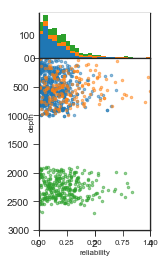

In [172]:
dft=pd.concat([df_v1,df_lgn])
metric = 'reliability'
limits = (0,4.)

f,axis=plt.subplots(1,1,figsize=(2,4))
ax = placeAxesOnGrid(f,[1,1],xspan=[0,1],yspan=[0,0.21])
ax.hist([dft[dft.structure=='V1'][dft.waveform_class=='rs'][metric],
         dft[dft.structure=='V1'][dft.waveform_class=='fs'][metric],
          dft[dft.structure=='LGN'][metric]],range=(limits[0],limits[1]),
           bins=25,stacked=True)
ax.set_xlim(limits[0],limits[1])
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis=u'both', which=u'both',length=0)
#axis.axis('off')
cleanAxes(ax,leftLabels=True)

ax = placeAxesOnGrid(f,[1,1],xspan=[0,1],yspan=[0.21,1.])
ax.plot(dft[dft.structure=='V1'][dft.waveform_class=='rs'][metric],
        dft[dft.structure=='V1'][dft.waveform_class=='rs'].depth,'o',ms=2.5,alpha=0.5)
ax.plot(dft[dft.structure=='V1'][dft.waveform_class=='fs'][metric],
        dft[dft.structure=='V1'][dft.waveform_class=='fs'].depth,'o',ms=2.5,alpha=0.5)
ax.plot(dft[dft.structure=='LGN'][metric],
        dft[dft.structure=='LGN'].depth,'o',ms=2.5,alpha=0.5)

ax.set_ylim(3000,0)
ax.set_xlim(limits[0],limits[1])

axis.set_xlabel(metric,size=8)
axis.set_ylabel('depth',size=8)
axis.tick_params(axis='both', which='major', labelsize=8)
axis.get_yaxis().set_ticks([])
plt.gcf().savefig('/Users/administrator/Dropbox/allenTransfer/temporal_figs/metrics_reliability_images.eps',format='eps')

In [165]:
dfv=dft

In [176]:
cosine_sim = np.ones(dfv.shape[0])*-2
current_nwb=''
for ii,index in enumerate(dfv.index):
    print '\r'+str(((ii+1)*100)/float(len(dfv.index)))+'%',
    u = dfv.cell[index]
    probe = dfv.probe[index]
    times = dfv.times[index]
    response_matrix = dfv.image_spikecount_matrix[index]
    responsive_images=dfv.responsive_images[index]
    current_nwb=''
    
    if not dfv.nwb_id[index] == current_nwb:
        nwb_data = nwbs[dfv.nwb_id[index]]
        current_nwb = dfv.nwb_id[index]
    if 'stimulus' in nwb_data.keys():       
        if 'flicker' in nwb_data['stimulus']['presentation'].keys():
            df_thisexperiment = dfv[dfv.nwb_id==dfv.nwb_id[index]]
            spike_times = np.array(nwb_data['processing'][probe]['UnitTimes'][str(u)]['times'])
            stimulus_times = np.array(nwb_data['stimulus']['presentation']['flicker']['timestamps'][::240])
#         if 'natural_images' in nwb_data['stimulus']['presentation'].keys():
#             df_thisexperiment = dfv[dfv.nwb_id==dfv.nwb_id[index]]
#             spike_times = np.array(nwb_data['processing'][probe]['UnitTimes'][u]['times'])
            
            #jitter from all responsive images
            try:
                cosine_similarity = rp.reliability(spike_times,stimulus_times,pre=0.0,post=15.,)
            except:
                cosine_similarity = np.nan
            cosine_sim[ii]=cosine_similarity
dfv['reliability_flicker']=cosine_sim
dfv.reliability[dfv.reliability==-2]=np.nan

100.0%


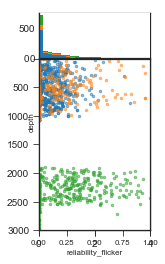

In [177]:
dft=dfv
metric = 'reliability_flicker'
limits = (0,4.)

f,axis=plt.subplots(1,1,figsize=(2,4))
ax = placeAxesOnGrid(f,[1,1],xspan=[0,1],yspan=[0,0.21])
ax.hist([dft[dft.structure=='V1'][dft.waveform_class=='rs'][metric],
         dft[dft.structure=='V1'][dft.waveform_class=='fs'][metric],
          dft[dft.structure=='LGN'][metric]],range=(limits[0],limits[1]),
           bins=25,stacked=True)
ax.set_xlim(limits[0],limits[1])
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis=u'both', which=u'both',length=0)
#axis.axis('off')
cleanAxes(ax,leftLabels=True)

ax = placeAxesOnGrid(f,[1,1],xspan=[0,1],yspan=[0.21,1.])
ax.plot(dft[dft.structure=='V1'][dft.waveform_class=='rs'][metric],
        dft[dft.structure=='V1'][dft.waveform_class=='rs'].depth,'o',ms=2.5,alpha=0.5)
ax.plot(dft[dft.structure=='V1'][dft.waveform_class=='fs'][metric],
        dft[dft.structure=='V1'][dft.waveform_class=='fs'].depth,'o',ms=2.5,alpha=0.5)
ax.plot(dft[dft.structure=='LGN'][metric],
        dft[dft.structure=='LGN'].depth,'o',ms=2.5,alpha=0.5)

ax.set_ylim(3000,0)
ax.set_xlim(limits[0],limits[1])

axis.set_xlabel(metric,size=8)
axis.set_ylabel('depth',size=8)
axis.tick_params(axis='both', which='major', labelsize=8)
axis.get_yaxis().set_ticks([])
plt.gcf().savefig('/Users/administrator/Dropbox/allenTransfer/temporal_figs/metrics_reliability_flicker.eps',format='eps')

In [178]:
cosine_sim = np.ones(dfv.shape[0])*-2
current_nwb=''
for ii,index in enumerate(dfv.index):
    print '\r'+str(((ii+1)*100)/float(len(dfv.index)))+'%',
    u = dfv.cell[index]
    probe = dfv.probe[index]
    times = dfv.times[index]
    response_matrix = dfv.image_spikecount_matrix[index]
    responsive_images=dfv.responsive_images[index]
    current_nwb=''
    
    if not dfv.nwb_id[index] == current_nwb:
        nwb_data = nwbs[dfv.nwb_id[index]]
        current_nwb = dfv.nwb_id[index]
    if 'stimulus' in nwb_data.keys():       
        if 'natural movie: TOE1' in nwb_data['stimulus']['presentation'].keys():
            df_thisexperiment = dfv[dfv.nwb_id==dfv.nwb_id[index]]
            spike_times = np.array(nwb_data['processing'][probe]['UnitTimes'][str(u)]['times'])
            stimulus_times = np.array(nwb_data['stimulus']['presentation']['natural movie: TOE1']['timestamps'][::900])
#         if 'natural_images' in nwb_data['stimulus']['presentation'].keys():
#             df_thisexperiment = dfv[dfv.nwb_id==dfv.nwb_id[index]]
#             spike_times = np.array(nwb_data['processing'][probe]['UnitTimes'][u]['times'])
            
            #jitter from all responsive images
            try:
                cosine_similarity = rp.reliability(spike_times,stimulus_times,pre=0.0,post=11.8,)
            except:
                cosine_similarity = np.nan
            cosine_sim[ii]=cosine_similarity
dfv['reliability_movie']=cosine_sim
dfv.reliability[dfv.reliability==-2]=np.nan

100.0%


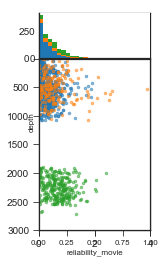

In [179]:
dft=dfv
metric = 'reliability_movie'
limits = (0,4.)

f,axis=plt.subplots(1,1,figsize=(2,4))
ax = placeAxesOnGrid(f,[1,1],xspan=[0,1],yspan=[0,0.21])
ax.hist([dft[dft.structure=='V1'][dft.waveform_class=='rs'][metric],
         dft[dft.structure=='V1'][dft.waveform_class=='fs'][metric],
          dft[dft.structure=='LGN'][metric]],range=(limits[0],limits[1]),
           bins=25,stacked=True)
ax.set_xlim(limits[0],limits[1])
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis=u'both', which=u'both',length=0)
#axis.axis('off')
cleanAxes(ax,leftLabels=True)

ax = placeAxesOnGrid(f,[1,1],xspan=[0,1],yspan=[0.21,1.])
ax.plot(dft[dft.structure=='V1'][dft.waveform_class=='rs'][metric],
        dft[dft.structure=='V1'][dft.waveform_class=='rs'].depth,'o',ms=2.5,alpha=0.5)
ax.plot(dft[dft.structure=='V1'][dft.waveform_class=='fs'][metric],
        dft[dft.structure=='V1'][dft.waveform_class=='fs'].depth,'o',ms=2.5,alpha=0.5)
ax.plot(dft[dft.structure=='LGN'][metric],
        dft[dft.structure=='LGN'].depth,'o',ms=2.5,alpha=0.5)

ax.set_ylim(3000,0)
ax.set_xlim(limits[0],limits[1])

axis.set_xlabel(metric,size=8)
axis.set_ylabel('depth',size=8)
axis.tick_params(axis='both', which='major', labelsize=8)
axis.get_yaxis().set_ticks([])
plt.gcf().savefig('/Users/administrator/Dropbox/allenTransfer/temporal_figs/metrics_reliability_movies.eps',format='eps')

# output data for Neural Population Control surrogate data generation
##### surrogate data generated in MATLAB using code from Gamaleldin et al., 2017

make a T x N x C tensor for each recording<br></br>
T = time, N = neuron, C = condition

In [126]:
from scipy.io import savemat

In [150]:
pre = 0.
post = 11.8
gaussian_filter = 5.
images_tensors_dan = {}
for j,nwb_path in enumerate(dft.nwb_id.unique()):
    if nwb_path in nwbs.keys():
        nwb_data = nwbs[nwb_path]
        df_exp = dft[dft.nwb_id==nwb_path]
        if 'natural_scenes' in nwb_data['stimulus']['presentation'].keys():
            stimulus_times = np.array(nwb_data['stimulus']['presentation']['natural_scenes']['timestamps'][::118])

            tensor = np.zeros((int((pre+post)*1000),df_exp.shape[0],np.shape(stimulus_times)[0]))

            #for each cell [N], get_binarized, which is T x C
            for i,index in enumerate(df_exp.index):
                spike_times = np.array(nwb_data['processing'][df_exp.probe[index]]['UnitTimes'][str(df_exp.cell[index])]['times'])
                try:
                    tensor[:,i,:] = np.array(rp.get_binarized(spike_times,stimulus_times,pre=pre,post=post,convolve=gaussian_filter)).T
                except: pass

            images_tensors_dan[nwb_path]=tensor

    #output mean tensor for matlab to read in and make shuffled data
    savemat(os.path.join(figure_folder,'image_tensors_dan.mat'),images_tensors_dan)

In [159]:
[len(strw) for strw in images_tensors_dan.keys()]

[63, 63, 61, 63, 54, 54, 60, 54, 54, 54, 54]

In [160]:
savemat(os.path.join(figure_folder,'image_tensors_dan.mat'),images_tensors_dan,long_field_names=True)

In [157]:
dft.nwb_id.unique()

array(['/Volumes/DATA2/temporal/nwbs/M310008_07-35-06_v1_angled_d.nwb',
       '/Volumes/DATA2/temporal/nwbs/M310008_08-23-22_v1_angled1_d2.nwb',
       '/Volumes/DATA2/temporal/nwbs/M310008_08-52-48_v1_angled3_d2.nwb',
       '/Volumes/DATA2/temporal/nwbs/M310017_09-23-41_v1_angled1.nwb',
       '/Volumes/DATA2/temporal/nwbs/M227398_insertion1_withEyetracking.nwb',
       '/Volumes/DATA2/temporal/nwbs/M260686_insertion1_V1_withEyetracking3.nwb',
       '/Volumes/DATA2/temporal/nwbs/M270512_insertion2_V1_angled3_6.nwb',
       '/Volumes/DATA2/temporal/nwbs/M276038_insertion3_V1_angled_7.nwb',
       '/Volumes/DATA2/temporal/nwbs/M270511_insertion5.nwb',
       '/Volumes/DATA2/temporal/nwbs/nwb_M14_actual_ds2.nwb',
       '/Volumes/DATA2/temporal/nwbs/nwb_M15_actual_ds2.nwb',
       '/Volumes/DATA2/temporal/nwbs/nwb_M16_actual_ds2.nwb',
       '/Volumes/DATA2/temporal/nwbs/nwb_M18_actual_ds2.nwb',
       '/Volumes/DATA2/temporal/nwbs/nwb_M26_actual_ds2.nwb',
       '/Volumes/DATA2/tempo

In [82]:
dft=df